In [1]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from scipy import optimize
from writeit import rewritePipes
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [3]:
fi = "../indata/Alameda62.0.0.inp" 
fc = "../indata/Alameda62.0.config"
n0 = PyNetwork(fi,fc,1)
print n0.Ls
print n0.Ns
print n0.Ds

[ 116.43  214.15   57.79   62.33   70.59   37.98   73.46   77.42   75.9
  101.19   77.72   82.91   41.45   39.93   75.22  108.51  104.24   58.83
  103.33  101.5   123.14   40.84   58.83   19.81   20.42  256.03  130.76
   10.36   60.96   91.44   13.11   60.96   91.44]
[24 43 12 13 15  8 15 16 16 21 16 17  9  8 16 22 21 12 21 21 25  9 12  4  5
 52 27  3 13 19  3 13 19]
[ 0.102  0.102  0.102  0.102  0.102  0.102  0.102  0.102  0.102  0.102
  0.102  0.102  0.102  0.102  0.102  0.102  0.051  0.102  0.051  0.051
  0.102  0.051  0.051  0.051  0.051  0.051  0.051  0.102  0.102  0.051
  0.102  0.102  0.051]


In [4]:
Ls = n0.Ls
T = 20
Mi = 20   #number of time steps in between writes
Nt = 40
Ttot = Nt*T
Np = n0.Nedges
a = 100
Ns = [int(l) for l in Ls]
Ds = [n0.Ds[0]]*Np
dx = [Ls[i]/Ns[i] for i in range(Np)]
M = int(T*a/(max(dx)*.8))*4
M = (M+Mi-M%Mi)  #round it up to be an even multiple of Mi
jt = n0.nodeTypes
Nn = len(jt)
bt = [1]*Nn
bv = [0]*Nn
r = [-1]*Nn
r[0] = 1
#r[16] = -1
bt[0] =0
h0s = [0]*Np
h0s = [.1*d*d/4*np.pi for d in Ds]
q0s = [1]*Np
Mrs =[0.007]*Np
#Mrs =[0.0]*Np
print T
print M
Nstar =1 #measuring point for each pipe
Hs =np.ndarray((Np,M/Mi*Nt))
print (T/float(M))/min(dx)*a
print min(Ns)
print T*Nt/60.
elevs = [127.10, 126.19, 98.76, 91.44, 83.82, 78.029, 70.74, 61.26, 53.95, 57.9, 58.52, 60.05, 60.66, 62.79, 63.70, 73.15, 76.81, 76.2, 86.26, 84.43, 88.09, 96.32, 96.012, 99.67, 101.80, 103.63, 101.80, 101.19, 101.50, 103.95, 117.96, 129.84, 87.48, 97.23]

20
9600
0.208308922132
10
13.3333333333


In [5]:
Hs =np.zeros((M/Mi*Nt,sum(Ns)))#[H0(t0), H1(t0),,,H7(t0);H0(t1)...; ]
Us =np.zeros((M/Mi*Nt,sum(Ns)))#
Hs2 = np.zeros((Np,M/Mi*Nt))
fn = "../indata/Alameda_m4"
oldinp = "../indata/Alameda62.0.0.inp"
(fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
n1 = PyNetwork(fi,fc,1)
dt = n1.T/float(n1.M)
Q00 = 0.0087
j = 0

ICdata = pickle.load(open('summary_results_saved_at2015_11_3_11_31_53.pkl','rb'))
Af = ICdata['Af']
Qf = ICdata['Qf']

for i in range(0,Np):
    #Ai = ((Ds[i]**2)/4.)*np.pi
    #initial condition empty
    #A0 = .05*Ai*ones(n1.Ns[i])
    #Q0 = 0*np.ones(n1.Ns[i])
    #subsequent runs use old data
    A0 = Af[i]
    Q0 = Qf[i]
    n1.setIC(i,A0,Q0)
#N = n1.Ns[j]
#p0 = PyPipe_ps(N,n1.Ds[j], n1.Ls[j],M,a)
#A00 = p0.AofH(20,False)
#n1.setIC(0,A00*np.ones(n1.Ns[0]), Q00*np.ones(n1.Ns[0]))
#n1.setIC(1,A00*np.ones(n1.Ns[1]), Q00*np.ones(n1.Ns[1]))
#Qb = Q00*np.ones(M+1)
#Qb = 0.00796866547379*np.ones(M+1)  #A = 100
#Qo = 0.04*np.ones(M+1)
#Ab = A00*np.ones(M+1)
#aa=arange(0,len(n1.nodeTypes))
#for j in range(len(aa[n1.nodeTypes==1])):
#    n1.setbVal(j,n1.Ds[i]*np.ones(M+1))
#n1.setbVal(0,Qb)
#for i in range(n1.Nedges):
#    print "%d    %d" %(i,n1.Ns[i])
#p0 = PyPipe_ps(n1.Ns[11],n1.Ds[11], n1.Ls[11],M, a)
print shape(Hs)

(19200, 2641)


In [6]:
#c= p0.Cgrav(1e-6,False) 
print a
print n1.Ls[16]/n1.Ns[16]
print n1.Ds[16]
print dt
print np.pi*(.05**2)/4.
n1.showCurrentData()
print n1.T

100
1.0
0.1
0.00208333333333
0.00196349540849
At time t = 0.000000
Data from pipe 0
A           Q
0.007969    0.015695
0.007968    0.015695
0.007968    0.015695
0.007968    0.015695
0.007968    0.015695
0.007968    0.015695
0.007968    0.015695
0.007968    0.015695
0.007967    0.015695
0.007967    0.015695
0.007967    0.015695
0.007967    0.015695
0.007967    0.015695
0.007967    0.015695
0.007967    0.015695
0.007966    0.015695
0.007966    0.015695
0.007966    0.015695
0.007966    0.015695
0.007966    0.015695
0.007966    0.015695
0.007966    0.015695
0.007965    0.015695
0.007965    0.015695
0.007965    0.015695
0.007965    0.015695
0.007965    0.015695
0.007965    0.015695
0.007965    0.015695
0.007964    0.015695
0.007964    0.015695
0.007964    0.015695
0.007964    0.015695
0.007964    0.015695
0.007964    0.015695
0.007964    0.015695
0.007963    0.015695
0.007963    0.015695
0.007963    0.015695
0.007963    0.015695
0.007963    0.015695
0.007963    0.015695
0.007963    0.015695

In [8]:
%%time 
Vs = [n1.getTotalVolume()]
for m in range(Nt):
    n1.runForwardProblem(dt)
    print 'T =%f'%(T*(m+1))
    Ntot = 0
    for j in range(Np):
        N = n1.Ns[j]
        p0 = PyPipe_ps(N,n1.Ds[j], n1.Ls[j],M,a)
        qh = n1.qhist(j)
        for n in range(1,M+1,Mi):
            Htemp=[p0.pbar(qh[idx_t(0,k,n,N)],False) for k in range(1,N+1)]
            Utemp = [qh[idx_t(1,k,n,N)]/qh[idx_t(0,k,n,N)] for k in range(1,N+1)]
            Hs[(n-1)/Mi+m*(M/Mi),Ntot:Ntot+N] = Htemp
            Us[(n-1)/Mi+m*(M/Mi),Ntot:Ntot+N] = Utemp
        Ntot+=N
        #Htemp2 = [p0.pbar(qh[idx_t(0,Nstar,n,n1.Ns[j])],False) for n in range(1,M+1,Mi)]
        #Hs2[j,m*(M/Mi):(M/Mi)*(m+1)] = Htemp2
    Vs.append(n1.getTotalVolume()) 
    print m
    print Vs
    n1.reset()

T =20.000000
0
[16.700105514216, 16.399422302156786]
T =40.000000
1
[16.700105514216, 16.399422302156786, 16.11142260411389]
T =60.000000
2
[16.700105514216, 16.399422302156786, 16.11142260411389, 15.81460096396097]
T =80.000000
3
[16.700105514216, 16.399422302156786, 16.11142260411389, 15.81460096396097, 15.514435886086998]
T =100.000000
4
[16.700105514216, 16.399422302156786, 16.11142260411389, 15.81460096396097, 15.514435886086998, 15.215556811081862]
T =120.000000
5
[16.700105514216, 16.399422302156786, 16.11142260411389, 15.81460096396097, 15.514435886086998, 15.215556811081862, 14.918140294400649]
T =140.000000
6
[16.700105514216, 16.399422302156786, 16.11142260411389, 15.81460096396097, 15.514435886086998, 15.215556811081862, 14.918140294400649, 14.626390522391956]
T =160.000000
7
[16.700105514216, 16.399422302156786, 16.11142260411389, 15.81460096396097, 15.514435886086998, 15.215556811081862, 14.918140294400649, 14.626390522391956, 14.343146425750932]
T =180.000000
8
[16.70010

In [9]:
blargh = np.zeros((M/Mi*Nt,sum(n1.Ns)))
print len(find(blargh<1))           
for m in range(Nt):
    Ntot=0
    for j in range(Np):
        N = n1.Ns[j]
        for n in range(1,M+1,Mi):
            blargh[(n-1)/Mi+m*(M/Mi),Ntot:Ntot+N]=np.ones(N)
        Ntot+=N


50707200


In [10]:
print m*M/Mi
print (M/Mi)*(m+1)
print Nstar

18720
19200
1


a = 100.0 m/s
inflow volume = -1844.24 gallons
1688.76583937
71.69105


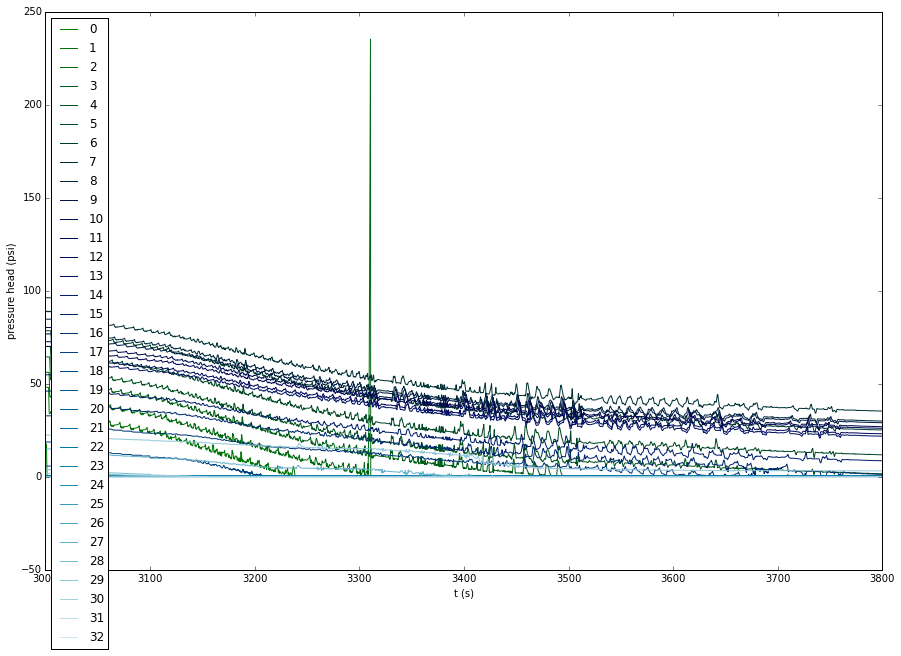

In [17]:
m2psi = 1.42

from matplotlib import cm
import matplotlib.colors as colors  
cNorm  = colors.Normalize(vmin=0, vmax=Np+1)
fig,ax = plt.subplots(figsize=(15,10))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean'))
t = linspace(0,Ttot,M/Mi*Nt)+3000
Ntot = 0
interesting = (16,18,19,20,29,32)
#interesting = (17,27,28,30,31,21)
#interesting = arange(23,24)
interesting = arange(0,Np)
for k in interesting:
    plot(t,m2psi*Hs[:,sum(Ns[0:k+1])-1],label="%d"%k, color = scalarMap.to_rgba(k))
    #plot(t,m2psi*Hs2[k,:],'g',label="%d"%k)# color = scalarMap.to_rgba(k))
xlabel('t (s)')
ylabel('pressure head (psi)')
#ylim(0,200)
#xlim(1100,1200)
legend(loc = 'upper left')
m32gal=264.172052
print "a = %.1f m/s" %a
print "inflow volume = %.2f gallons"%((Vs[-1]-Vs[0])*m32gal)
k = 17
print norm(Hs2[k,:]-Hs[:,sum(Ns[0:k])])
print n1.solve_time*Nt/60

116
[1673 1674 1675 1676 1677 1678 1679 1680 1681 1682 1683 1684 1685 1686 1687
 1688 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700 1701 1702
 1703 1704 1705 1706 1707 1708 1709 1710 1711 1712 1713 1714 1715 1716 1717
 1718 1719 1720 1721 1722 1723 1724 1725 1726 1727 1728 1729 1730 1731 1732
 1733 1734 1735 1736 1737 1738 1739 1740 1741 1742 1743 1744 1745 1746 1747
 1748 1749 1750 1751 1752 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762
 1763 1764 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777
 1778 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 1792]
0.00208333333333
100
103.0
101.0
123.0


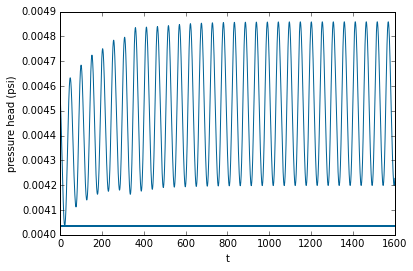

In [111]:
interesting = arange(sum(Ns[0:20])+3, sum(Ns[0:21]))
t = linspace(0,T*Nt,M/Mi*Nt)
print Ns[0]
cNorm  = colors.Normalize(vmin=0, vmax=len(interesting)+5)
scalarMap2 = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean'))
print interesting
for i in interesting:
    plot(t,Hs[:,i], color = scalarMap.to_rgba(20))
print dt
print a
#xticks(linspace(280,290,11))
grid(False)
xlabel('t')
#xlim(0,50)
ylabel('pressure head (psi)')
print n1.Ls[18]
print n1.Ls[19]
print n1.Ls[20]
legend(loc = 'upper left')


In [93]:
# combination that works to 140 s: Q0 = 0.05Af, r = -1 everywhere.

In [13]:
print n1.solve_time*Nt/60

111.851164


In [18]:

Note = "initial condition is (Af,Qf) from summary_results_saved_at2015_11_3_11_31_53.pkl \
    boundary condition is r=1 at node 0.\
    all other junctions have r = -1 \
    base inp file is %s"%oldinp

In [19]:
Af = []
Qf = []
for k in range(Np):
    q = n1.q(k)
    Af.append(np.array(q[0:Ns[k]]))
    Qf.append(np.array(q[ Ns[k]:]))

In [20]:
import time
solve_t = (n1.solve_time)*Nt
t = time.localtime()
s = "%d_%d_%d_%d_%d_%d"%(tuple([t[i] for i in range(6)]))
f1=  open('results_%d_s_saved_at%s.pkl'%(int(Ttot),s),'wb')
data = {'Hs':Hs, 'Us':Us, 'elevs':elevs,'T':T,'Tot':Ttot,
        'conns': n1.conn, 
        'Ds': n1.Ds, 
        'Ls':n1.Ls,
        'Ns':n1.Ns,
        'Mrs':Mrs,
        'M':M, 
        'Nt': Nt,
        'Ttot':Ttot,
        'r':r, 
        'bt':bt,
        'bv':bv,
        'Mi': Mi, 'a':a, 'solve_t':solve_t, 'Q00': Q00,
        'notes':Note,
         "reported time":"CPU times: user 1h 13min 28s, sys: 15.8 s, total: 1h 13min 43s\
Wall time: 1h 13min 39s", 
       'Af':Af,
       'Qf': Qf,
       'Vs':Vs}
pickle.dump(data,f1)
f1.close()

In [21]:
print len(Af)
print len(Qf)

33
33


In [22]:
print f1

<closed file 'results_800_s_saved_at2015_11_3_13_54_5.pkl', mode 'wb' at 0x168f50db0>


In [23]:
for k in range(Np):
    print "%d     %f"%(k,m2psi*Hs[-1,sum(Ns[0:k])+5])

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     3.363049
6     13.105622
7     26.201829
8     35.219517
9     30.090602
10     29.111293
11     27.072520
12     25.871804
13     23.114008
14     21.049146
15     8.476297
16     0.037562
17     2.378395
18     0.018608
19     0.011602
20     0.005730
21     0.037731
22     0.070772
23     0.757025
24     0.005341
25     0.006483
26     0.005730
27     0.024265
28     2.260468
29     3.402599
30     0.008435
31     0.006884
32     0.005730


In [30]:
f2 = open('summary_results_saved_at%s.pkl'%s,'wb')

In [24]:
data = {'elevs':elevs,'T':T,'Tot':Ttot,
        'conns': n1.conn, 
        'Ds': n1.Ds, 
        'Ls':n1.Ls,
        'Ns':n1.Ns,
        'Mrs':Mrs,
        'M':M, 
        'Nt': Nt,
        'Ttot':Ttot,
        'r':r, 
        'bt':bt,
        'bv':bv,
        'Mi': Mi, 'a':a, 'solve_t':solve_t, 'Q00': Q00,
        'notes':Note,
         "reported time":"CPU times: user 1h 13min 28s, sys: 15.8 s, total: 1h 13min 43s\
Wall time: 1h 13min 39s ", 
       'Af':Af,
       'Qf': Qf,
     'Vs':Vs}
pickle.dump(data,f2)
f2.close()

NameError: name 'f2' is not defined

In [38]:
print f2


<closed file 'summary_results_saved_at2015_11_3_11_31_53.pkl', mode 'wb' at 0x1f9080c90>


In [59]:
print Qf

[array([ 0.01569549,  0.01569549,  0.01569549,  0.01569549,  0.01569549,
        0.01569549,  0.01569549,  0.01569548,  0.01569548,  0.01569548,
        0.01569548,  0.01569548,  0.01569548,  0.01569548,  0.01569548,
        0.01569548,  0.01569548,  0.01569548,  0.01569548,  0.01569548,
        0.01569548,  0.01569548,  0.01569548,  0.01569548,  0.01569548,
        0.01569548,  0.01569548,  0.01569548,  0.01569548,  0.01569548,
        0.01569548,  0.01569548,  0.01569548,  0.01569548,  0.01569548,
        0.01569548,  0.01569548,  0.01569548,  0.01569548,  0.01569548,
        0.01569548,  0.01569548,  0.01569548,  0.01569548,  0.01569548,
        0.01569548,  0.01569548,  0.01569547,  0.01569547,  0.01569547,
        0.01569547,  0.01569547,  0.01569547,  0.01569547,  0.01569547,
        0.01569547,  0.01569547,  0.01569547,  0.01569547,  0.01569547,
        0.01569547,  0.01569547,  0.01569547,  0.01569547,  0.01569547,
        0.01569547,  0.01569547,  0.01569547,  0.01569547,  0.0